# Message Analysis

## Preparation

The following two scripts are activated to:
1. Set up the MongoDB connection and
2. Read the pre-generated ID-table to fetch names of roles and channels.

In [1]:
%run -i scripts/setup-mongo.py
%run -i scripts/read-idtable.py

In [2]:
import matplotlib.pyplot as plt
from dateutil.parser import parse as parse_date
from datetime import date
from calendar import monthrange

## Data Structure

Following, the data will be queried from the database collection `messages`.

A message document in the database looks like following:
```json
{
  "_id": "5cc599568dd9608c81d434da",
  "guildid": "307084334198816769",
  "channelid": "533817185488076807",
  "roleids": [
    "533817176637964308",
    "533817177824821248",
    "533817178852425749",
    "533817180081487872",
    "533833573103566858"
  ],
  "bot": false,
  "contentlen": 4,
  "timestamp": "2019-04-28T12:15:18.883Z",
  "mentionedroleids": [],
  "mentions": 0,
  "attachment": false
}
```

In [3]:
# Get messages collection
coll_messages = mongo_db['messages']
# Query all documents from collection
messages_data = coll_messages.find({})

This is the total ammount of message data sets which were analyzed and saved since start of data collection:

In [4]:
coll_messages.count_documents({})

318448

## Messages per Day and Month

The plot below shows two datasets:
1. Messages per Day  
   *Total summ of messages created at this day.*
2. Avg. Messages per Day each Month  
   *Avergae messages this month per day.*

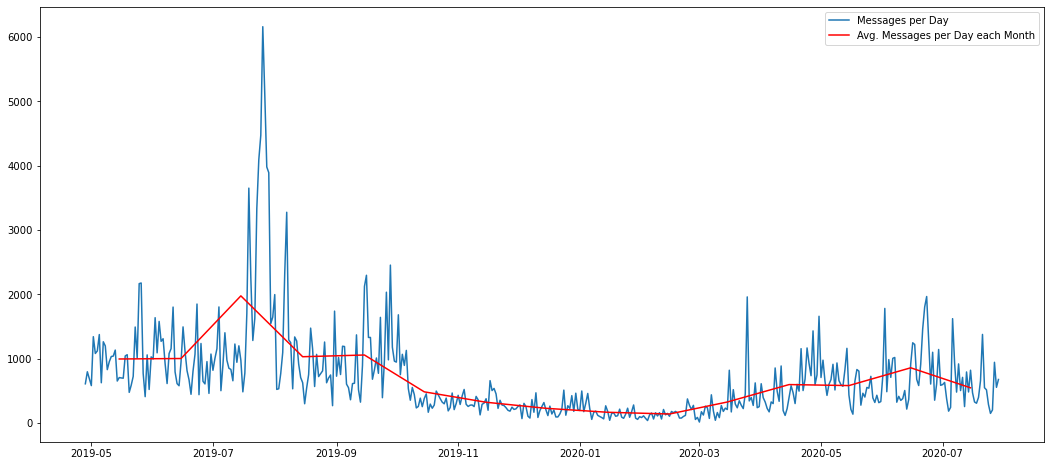

In [5]:
%matplotlib inline

msgs_per_day = {}
msgs_per_month = {}

# Go through all documents and put the data to
# the data maps created above.
for m in messages_data.clone():
    day = parse_date(str(m.get('timestamp')).split(' ')[0])
    month = date(day.year, day.month, 15)
    
    if day not in msgs_per_day:
        msgs_per_day[day] = 0
    msgs_per_day[day] += 1
    
    if month not in msgs_per_month:
        msgs_per_month[month] = 0
    msgs_per_month[month] += 1

xday = []
yday = []
xmonth = []
ymonth = []

for day, n in msgs_per_day.items():
    xday.append(day)
    yday.append(n)
    
# As you can see here, the first month is excluded
# because its value is 0 at this point.       |
#                                            \/
for month, n in list(msgs_per_month.items())[1:]:
    xmonth.append(month)
    mr = monthrange(month.year, month.month)
    ymonth.append(n / mr[1])
    
plt.rcParams['figure.figsize'] = (18,8)
plt.plot(xday,yday)
plt.plot(xmonth,ymonth, 'r')
plt.legend(('Messages per Day', 'Avg. Messages per Day each Month'), loc=1)
plt.show()

## Messages per Channel

As you can see, I made a huge failure when creating the `Kirby` bot. I thought just collecting the channel and role IDs would be better than also collecting the names of the roles and channels. On the one hand side just to save some space when storing the data and on the other hand side to bypass inconsistent data when channels or roles are renamed.

The plan was to recover the names of the channels and roles when analyzing the data using the Discord API. The problem is, just because the project went for so long time now, some channels got removed entirely, so their IDs don't match anymore and names can not be recovered.

So, dont be confused by the random IDs visible in the chart. These are the IDs of the channels which do not exist anymore.

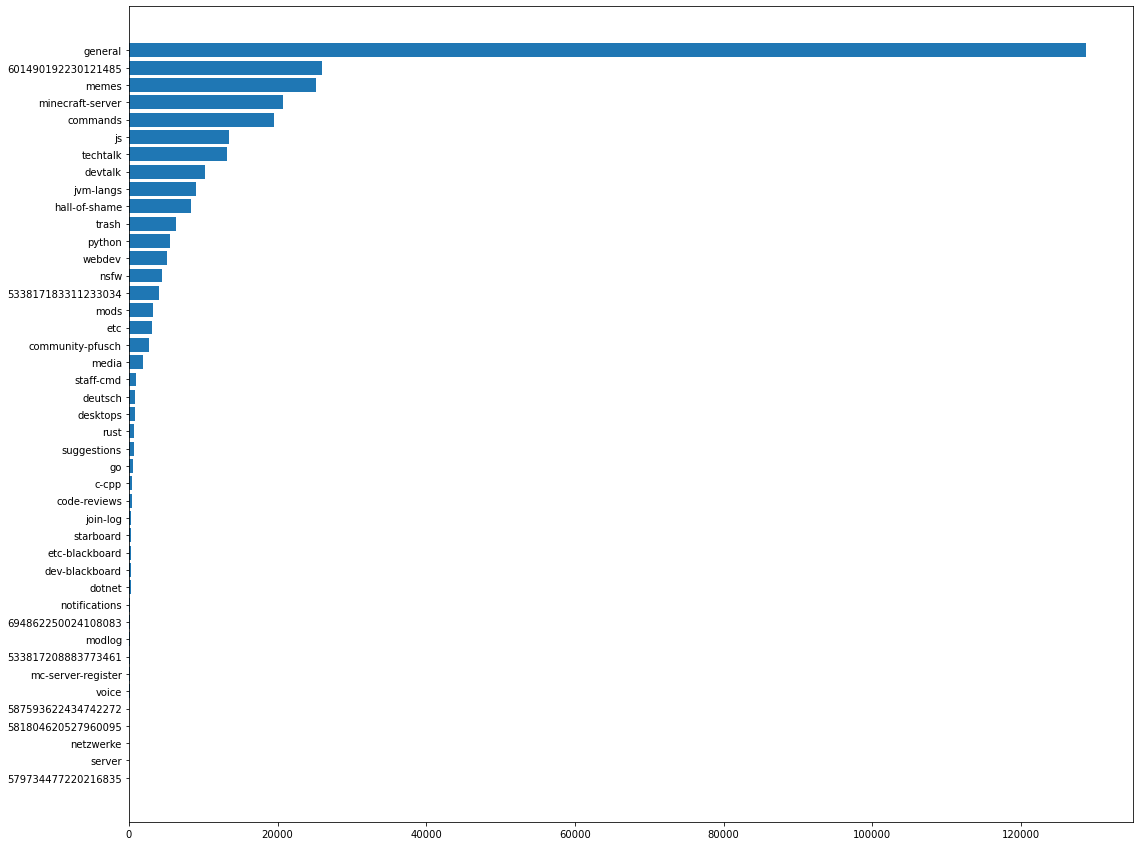

In [6]:
messages_per_channel = {}

for m in messages_data.clone():
    chanid = m.get('channelid')
    channame = get_channel_name(chanid)
    if channame not in messages_per_channel:
        messages_per_channel[channame] = 0
    messages_per_channel[channame] += 1
    
channels = []
n_msgs = []

for c, n in sorted(messages_per_channel.items(), key=lambda x: x[1]):
    channels.append(c)
    n_msgs.append(n)

plt.rcParams['figure.figsize'] = (18,15)
plt.barh(channels, n_msgs)
plt.show()

## Messages per Role

The plot below shows the summ of messages from authors with the listed roles. You need to take in perspective that when a author has multiple roles, the message will be counted for each one of that roles. So the summ of messages in this plot is way larger than the summ of all messages sent.

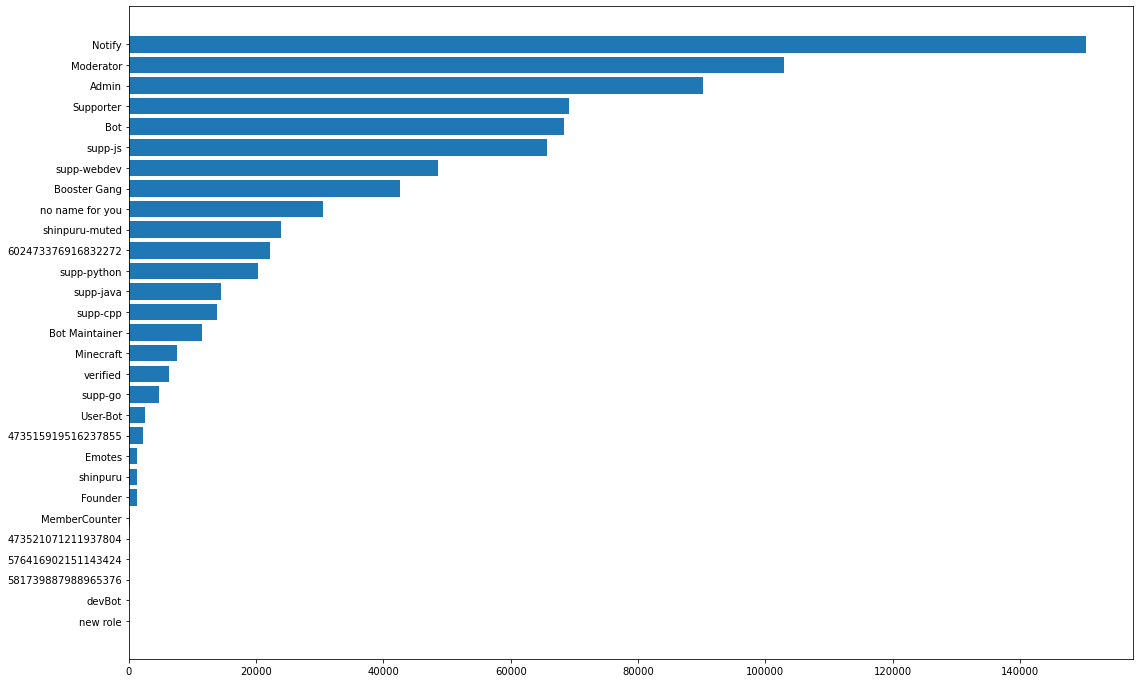

In [7]:
messages_per_role = {}

for m in messages_data.clone():
    roleids = m.get('roleids')
    for rid in roleids:
        rname = get_role_name(rid)
        # THis role has emojis in it. This is just to
        # exclude them in this specific case.
        # I know, dirty, but works. :D
        if rname.startswith('Booster Gang'):
            rname = 'Booster Gang'
        if rname not in messages_per_role:
            messages_per_role[rname] = 0
        messages_per_role[rname] += 1
    
roles = []
n_msgs = []

for r, n in sorted(messages_per_role.items(), key=lambda x: x[1]):
    roles.append(r)
    n_msgs.append(n)

plt.rcParams['figure.figsize'] = (18,12)
plt.barh(roles, n_msgs)
plt.show()

## Message Length over Time

Now, we take a look at the message length on average on each day over time.

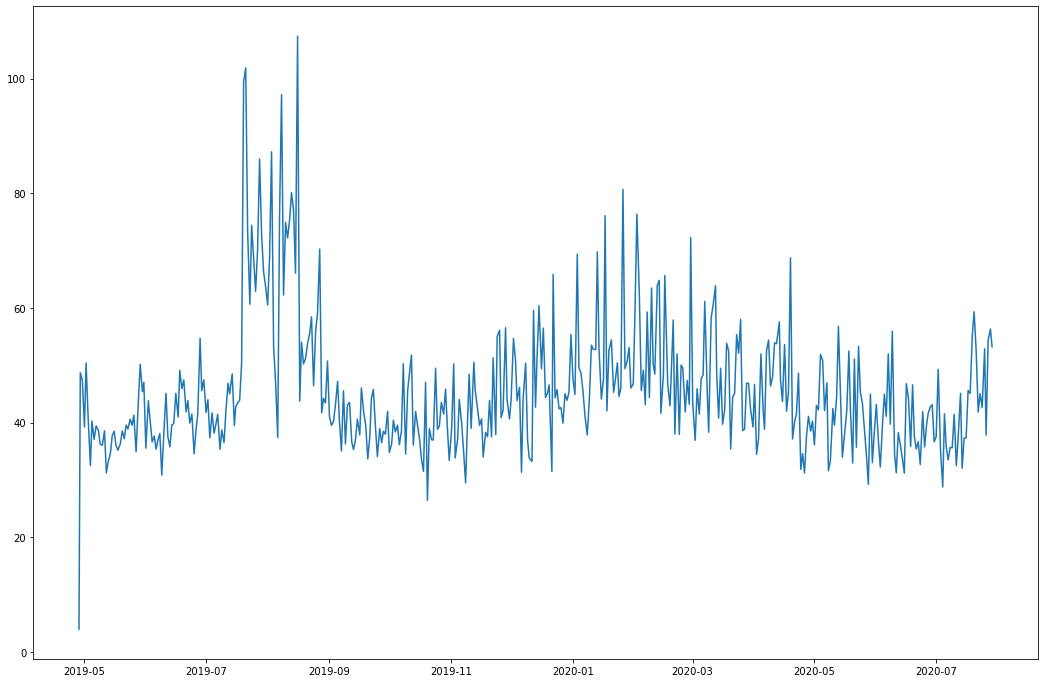

In [8]:
lengths = []
dates = []

last_day = 0
c_length = 0
count = 0
for m in messages_data.clone():
    date = m.get('timestamp')
    c_length += m.get('contentlen')
    count += 1
    if date.day != last_day:
        last_day = date.day
        lengths.append(c_length / count)
        dates.append(date)
        c_length = 0
        count = 0
        
plt.plot(dates, lengths)
plt.show()

And now, we combine the message length plot with the average message count per day.

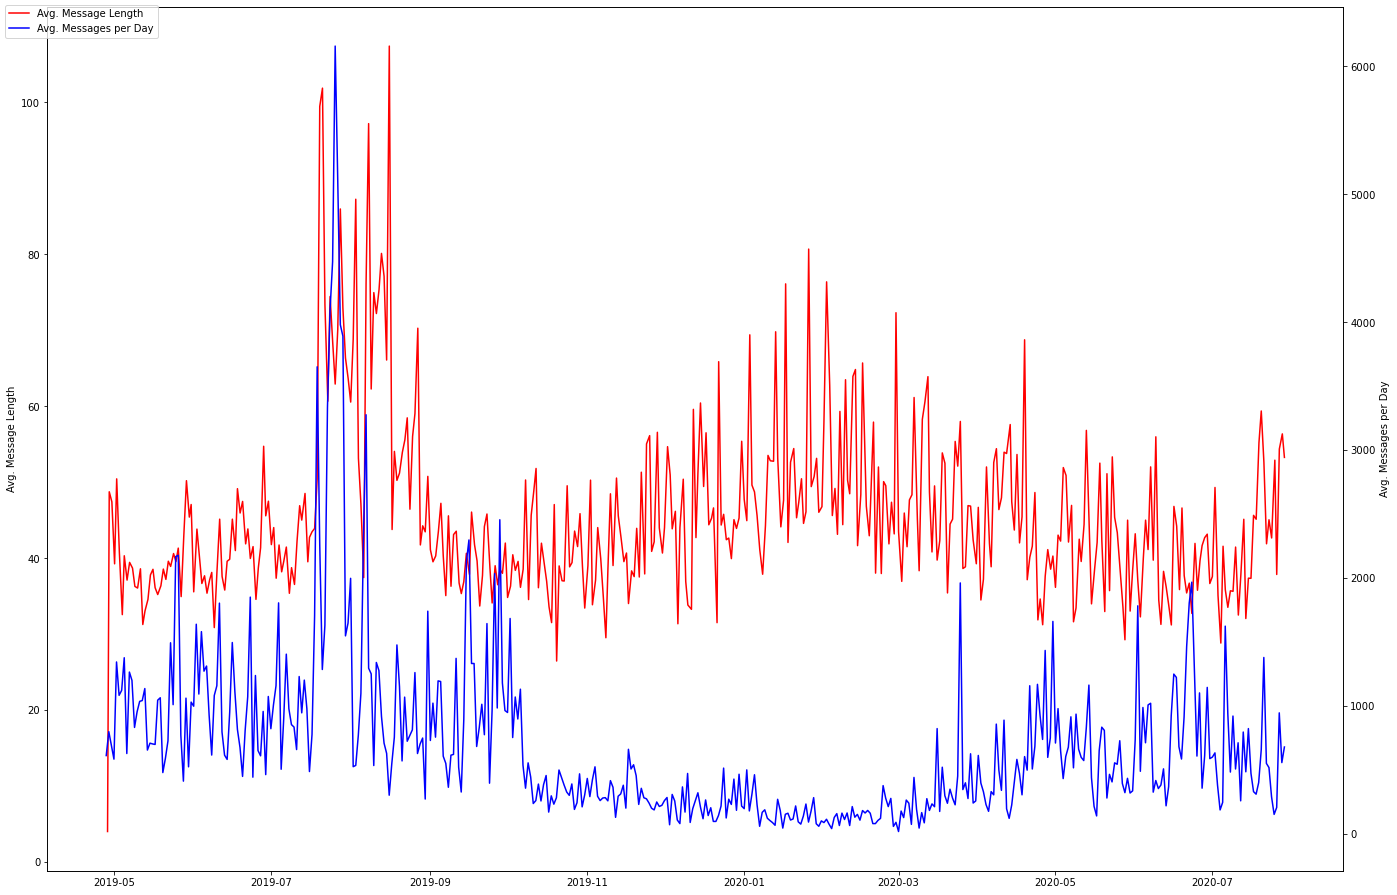

In [16]:
x_msgs_pd = []
y_msgs_pd = []

for day, n in msgs_per_day.items():
    x_msgs_pd.append(day)
    y_msgs_pd.append(n)

fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax1.set_ylabel("Avg. Message Length")
ax2 = ax1.twinx()
ax2.set_ylabel("Avg. Messages per Day")
    
ax1.plot(dates, lengths, 'r')
ax2.plot(x_msgs_pd, y_msgs_pd, 'b')

fig.legend(('Avg. Message Length', 'Avg. Messages per Day'), loc='upper left')

plt.show()